In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic regression data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(X) + 0.1 * np.random.randn(100, 1)

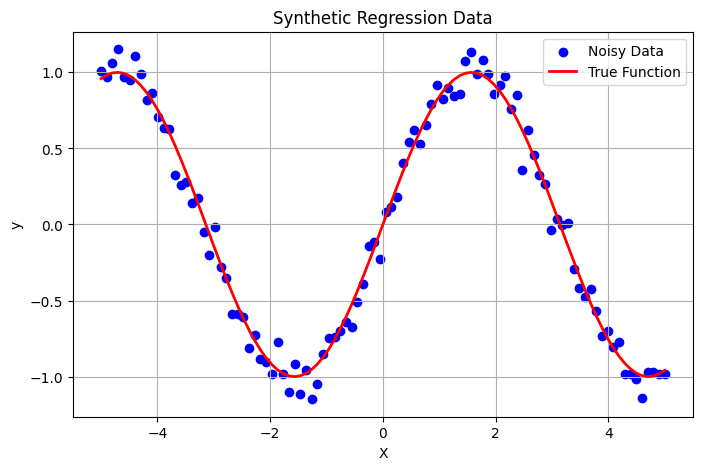

In [13]:
# Plot the data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Noisy Data')  # Scatter plot
plt.plot(X, np.sin(X), color='red', linewidth=2, label='True Function')  # True sin(X)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Regression Data")
plt.legend()
plt.grid()
plt.show()

In [14]:
print(X.shape)
print(y.shape)
print(X[25])   # value b/w -5 - 5 
print(y[25])    # [-1 1 ] + noise 

(100, 1)
(100, 1)
[-2.47474747]
[-0.60741782]


In [15]:

# Neural Network Layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) 
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [16]:
# Activation Function (ReLU)
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Mean Squared Error (MSE) Loss
class Loss_MSE:
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)

    def backward(self, y_pred, y_true):
        self.dinputs = -2 * (y_true - y_pred) / y_true.shape[0]

In [17]:
# Optimizers
class Optimizer_SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases

In [18]:
class Optimizer_Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_w = {}
        self.velocity_b = {}
    
    def update_params(self, layer):
        if layer not in self.velocity_w:
            self.velocity_w[layer] = np.zeros_like(layer.weights)
            self.velocity_b[layer] = np.zeros_like(layer.biases)

        self.velocity_w[layer] = self.momentum * self.velocity_w[layer] - self.learning_rate * layer.dweights
        self.velocity_b[layer] = self.momentum * self.velocity_b[layer] - self.learning_rate * layer.dbiases

        layer.weights += self.velocity_w[layer]
        layer.biases += self.velocity_b[layer]

In [19]:

class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.01, decay=0.99, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.cache_w = {}
        self.cache_b = {}

    def update_params(self, layer):
        if layer not in self.cache_w:
            self.cache_w[layer] = np.zeros_like(layer.weights)
            self.cache_b[layer] = np.zeros_like(layer.biases)

        self.cache_w[layer] = self.decay * self.cache_w[layer] + (1 - self.decay) * (layer.dweights ** 2)
        self.cache_b[layer] = self.decay * self.cache_b[layer] + (1 - self.decay) * (layer.dbiases ** 2)

        layer.weights -= self.learning_rate * layer.dweights / (np.sqrt(self.cache_w[layer]) + self.epsilon)
        layer.biases -= self.learning_rate * layer.dbiases / (np.sqrt(self.cache_b[layer]) + self.epsilon)

In [20]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.iterations = 0
        self.m_w = {}
        self.v_w = {}
        self.m_b = {}
        self.v_b = {}

    def update_params(self, layer):
        if layer not in self.m_w:
            self.m_w[layer] = np.zeros_like(layer.weights)
            self.v_w[layer] = np.zeros_like(layer.weights)
            self.m_b[layer] = np.zeros_like(layer.biases)
            self.v_b[layer] = np.zeros_like(layer.biases)

        self.m_w[layer] = self.beta_1 * self.m_w[layer] + (1 - self.beta_1) * layer.dweights
        self.m_b[layer] = self.beta_1 * self.m_b[layer] + (1 - self.beta_1) * layer.dbiases
        
        self.v_w[layer] = self.beta_2 * self.v_w[layer] + (1 - self.beta_2) * (layer.dweights ** 2)
        self.v_b[layer] = self.beta_2 * self.v_b[layer] + (1 - self.beta_2) * (layer.dbiases ** 2)

        m_w_hat = self.m_w[layer] / (1 - self.beta_1 ** (self.iterations + 1))
        v_w_hat = self.v_w[layer] / (1 - self.beta_2 ** (self.iterations + 1))
        m_b_hat = self.m_b[layer] / (1 - self.beta_1 ** (self.iterations + 1))
        v_b_hat = self.v_b[layer] / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        layer.biases -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        self.iterations += 1



In [21]:
def train_and_plot():
    optimizer_choice = optimizer_var.get()
    learning_rate = float(lr_entry.get())

    optimizers = {
        "SGD": Optimizer_SGD(learning_rate),
        "Momentum": Optimizer_Momentum(learning_rate),
        "RMSprop": Optimizer_RMSprop(learning_rate),
        "Adam": Optimizer_Adam(learning_rate)
    }
    optimizer = optimizers[optimizer_choice]

    dense1 = Layer_Dense(1, 2)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(2, 3)
    activation2 = Activation_ReLU()  
    dense3 = Layer_Dense(3, 1)
    loss_function = Loss_MSE()

    losses = []

    for epoch in range(100):
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        dense3.forward(activation2.output)

        # Loss calculation
        loss = loss_function.forward(dense3.output, y)
        losses.append(loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

        # Backward pass
        loss_function.backward(dense3.output, y)
        dense3.backward(loss_function.dinputs)
        activation2.backward(dense3.dinputs)  
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
 
 
        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)  

        # Plot loss
        ax_loss.clear()
        ax_loss.plot(losses, label=f'{optimizer_choice} Loss')
        ax_loss.legend()
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        canvas.draw()


* In your code, the weights and biases for each dense layer are stored inside the corresponding dense layer objects.

* Each dense layer (like dense1, dense2, dense3) has attributes to store its weights and biases, and their gradients during backpropagation

* How It Works
* self.weights → Stores layer weights
* self.biases → Stores layer biases
* self.dweights → Stores gradients for weights during backprop
* self.dbiases → Stores gradients for biases during backprop
* Each time backprop runs, gradients (dweights, dbiases) are computed.

Epoch 0, Loss: 0.5607
Epoch 10, Loss: 0.5606
Epoch 20, Loss: 0.5606
Epoch 30, Loss: 0.5606
Epoch 40, Loss: 0.5606
Epoch 50, Loss: 0.5606
Epoch 60, Loss: 0.5606
Epoch 70, Loss: 0.5606
Epoch 80, Loss: 0.5606
Epoch 90, Loss: 0.5606


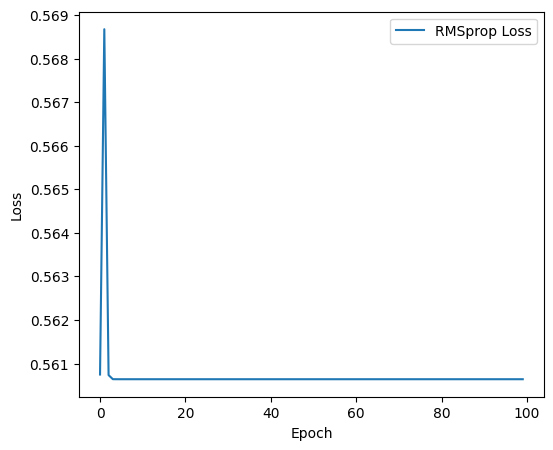

In [22]:
## GUI SETUP FOR Optimizer Visualization

import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
root = tk.Tk()
root.title("Optimizer Visualization")
frame = tk.Frame(root)
frame.pack(pady=20)

optimizer_var = tk.StringVar(value="SGD")
optimizer_menu = ttk.Combobox(frame, textvariable=optimizer_var, values=["SGD", "Momentum", "RMSprop", "Adam"])
optimizer_menu.grid(row=0, column=1)

lr_entry = tk.Entry(frame)
lr_entry.grid(row=1, column=1)
lr_entry.insert(0, "0.01")

train_button = tk.Button(frame, text="Train", command=train_and_plot)
train_button.grid(row=2, columnspan=2)

fig, ax_loss = plt.subplots(figsize=(6, 5))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack()

root.mainloop()